# Metadata

```yaml

Author:   Qing Liu
Date:     02/05/2023
```

**Purpose**:  We import a collection of texts and convert to F2. Then we annotate the collection to create an F3-level model.

# Set Up

In [1]:
data_home = "/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data"
local_lib = "/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/lib"

In [2]:
import os
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px

## Create Lib

In [3]:
def create_library_df(main_folder):
    data = []

    for root, _, files in os.walk(main_folder):
        for file in files:
            if file.endswith('.txt'):  # Check if it's a plain text file
                file_path = os.path.join(root, file)
                subfolder = os.path.relpath(root, main_folder)
                file_name = os.path.splitext(file)[0]
                data.append((file_path, file_name, subfolder))

    columns = ['File Path', 'document_id', 'Subfolder']
    df = pd.DataFrame(data, columns=columns)

    return df

In [4]:
main_folder = '/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data'
df = create_library_df(main_folder)

In [5]:
df[['site_id', 'scenario_id']] = df['Subfolder'].str.split('/', expand=True)

In [6]:
LIB = df.drop('Subfolder', axis=1).set_index('document_id')
LIB

,File Path,site_id,scenario_id
document_id,,,
02_004_22c_100,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN
02_004_22c_074,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN
02_004_22c_061,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN
02_004_22c_049,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN
02_004_32c_014,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN
...,...,...,...
01_004_12c_022,/Users/poppy/Documents/TeachSim Project/Robert...,UVA,QF
01_004_12c_023,/Users/poppy/Documents/TeachSim Project/Robert...,UVA,QF
01_004_12c_037,/Users/poppy/Documents/TeachSim Project/Robert...,UVA,QF


## Build Corpus

In [7]:
import os
import glob
import pandas as pd

main_folder = '/Users/poppy/Documents/TeachSim Project/Robertson_Semantic/Data'

# Traverse all subfolders and read text files
documents = []

for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.endswith(".txt"):
            filepath = os.path.join(root, file)
            with open(filepath, 'r', encoding='utf-8') as f:
                content = f.read()
                paragraphs = content.split('\n\n')
                documents.append({'document_id': os.path.splitext(file)[0], 'content': content})

# Convert the list of dictionaries to a DataFrame
corpus = pd.DataFrame(documents)

In [8]:
#remove "transcripted by ..."
# Function to remove the "Transcribed by https://otter.ai" text
def remove_transcription_info(text):
    return text.replace("Transcribed by https://otter.ai", "")

# Remove the text from the content column
corpus['content'] = corpus['content'].apply(remove_transcription_info)

In [9]:
corpus

,document_id,content
0,02_004_22c_100,"Kristyn 0:00 \nSo okay, tell me how did you ..."
1,02_004_22c_074,Anna 0:00 \nsimulation. Okay. Thanks so much...
2,02_004_22c_061,"Teacher 0:00 \n Oh my gosh, that was so fun...."
3,02_004_22c_049,COACH 0:00 \nHow'd you feel about that simul...
4,02_004_32c_014,Coach 0:00 \nHow did you feel about that one...
...,...,...
209,01_004_12c_022,"Teacher 0:00 \nSorry\n\nCoach 0:01 \nOh, y..."
210,01_004_12c_023,"Coach 0:01 \nHey, how did that go for you? H..."
211,01_004_12c_037,Coach 0:01 \nSo how did that go for you?\n\n...
212,01_004_12c_035,"Coach 0:00 \nOkay. Alright, so how did that ..."


## Use NLTK to Chunk Sentence and Parse Tokens

In [10]:
import pandas as pd
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/poppy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from nltk import pos_tag

In [12]:
#define ohco
ohco = ['document_id', 'paragraph_id', 'sentence_id', 'token_id']

## Parse text into paragraphs

In [13]:
import regex
import pandas as pd

In [14]:
def parse_content(text):
    lines = text.split('\n')
    parsed_data = []
    current_speaker = None
    current_timestamp = None
    current_content = []
    previous_line_empty = True
    
    for line in lines:
        if not line.strip():
            previous_line_empty = True
            continue
        
        if previous_line_empty:
            match = regex.search(r'^(\w.+?)\s{1,2}(\d+:\d+)(.*)$', line)
            if match:
                if current_speaker is not None:
                    parsed_data.append((current_speaker, current_timestamp, ' '.join(current_content)))
                    
                current_speaker = match.group(1)
                current_timestamp = match.group(2)
                current_content = [match.group(3).strip()]
                previous_line_empty = False
                continue
        
        current_content.append(line.strip())
        previous_line_empty = False
    
    if current_speaker is not None:
        parsed_data.append((current_speaker, current_timestamp, ' '.join(current_content)))
        
    return parsed_data

In [15]:
parsed_data = []

for index, row in corpus.iterrows():
    document_id = row['document_id']
    content = row['content']
    parsed_paragraphs = parse_content(content)
    
    for speaker, timestamp, paragraph in parsed_paragraphs:
        parsed_data.append((document_id, speaker, timestamp, paragraph))

In [16]:
PARA = pd.DataFrame(parsed_data, columns=['document_id', 'speaker', 'timestamp', 'content'])
PARA['paragraph_id'] = PARA.groupby('document_id').cumcount() + 1
PARA = PARA[['document_id', 'paragraph_id', 'content', 'speaker', 'timestamp']]


In [17]:
PARA['speaker'].unique()
##So this format look good to me

array(['Kristyn', 'Teacher', 'Anna', 'COACH', 'TEACHER', 'Coach',
       'Unknown Speaker', 'coach', 'Jamie', 'Participant', 'Jasmine',
       'Participantr', 'Speaker 1', 'TeachSIM Staff', 'TeachSIM',
       'Participant ', 'Sim Staff', 'Jamie McLemore', 'Ethan'],
      dtype=object)

In [18]:
PARA

,document_id,paragraph_id,content,speaker,timestamp
0,02_004_22c_100,1,"So okay, tell me how did you feel about that?...",Kristyn,0:00
1,02_004_22c_100,2,"I mean, like, is there anything that I can li...",Teacher,0:05
2,02_004_22c_100,3,"Yeah, I think that's a fair question. Um, I t...",Kristyn,0:13
3,02_004_22c_100,4,"Um, well, the more specific you are, the less...",Teacher,1:29
4,02_004_22c_100,5,Totally. If we think back to that scenario th...,Kristyn,1:39
...,...,...,...,...,...
4328,01_004_12c_008,22,That's true. It does say that good reading. I...,Teacher,5:37
4329,01_004_12c_008,23,"Oh, well, in paragraph 20. It says her heart ...",Coach,5:44
4330,01_004_12c_008,24,"Yeah, maybe because people do have their hear...",Teacher,5:54
4331,01_004_12c_008,25,It says that... great job there. Great job fo...,Coach,6:04


## Chunk into sentence

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/poppy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Split paragraphs into sentences
PARA['sentences'] = PARA['content'].apply(nltk.sent_tokenize)

# Explode the sentences column
SENT = PARA.explode('sentences')

# Create sentence_id within each paragraph
SENT['sentence_id'] = SENT.groupby(['document_id', 'paragraph_id']).cumcount() + 1

# Rearrange columns and set hierarchical index
SENT = SENT[['document_id', 'paragraph_id', 'sentence_id', 'sentences', 'speaker']]

In [21]:
SENT

,document_id,paragraph_id,sentence_id,sentences,speaker
0,02_004_22c_100,1,1,"So okay, tell me how did you feel about that?",Kristyn
0,02_004_22c_100,1,2,Just give me your thoughts.,Kristyn
0,02_004_22c_100,1,3,You can vent.,Kristyn
1,02_004_22c_100,2,1,"I mean, like, is there anything that I can li...",Teacher
2,02_004_22c_100,3,1,"Yeah, I think that's a fair question.",Kristyn
...,...,...,...,...,...
4331,01_004_12c_008,25,4,I think that you're on it.,Coach
4331,01_004_12c_008,25,5,I think that you're ready for your next round.,Coach
4331,01_004_12c_008,25,6,Wait.,Coach
4331,01_004_12c_008,25,7,Are you ready to dive in to the second round o...,Coach


## Expand contractions

In [22]:
# pip install contractions

In [23]:
import contractions

In [24]:
# Define the expand_contractions function
def expand_contractions(text):
    return contractions.fix(text)

# Apply the function to the "sentence" column
SENT['sentences'] = SENT['sentences'].apply(expand_contractions)

## Tokenize sentence

In [25]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/poppy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/poppy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
def custom_tokenize(sentence):
    pattern = r'\w+\'\w+|\w+'
    tokens = nltk.regexp_tokenize(sentence, pattern)
    pos_tagged_tokens = pos_tag(tokens)
    return pos_tagged_tokens

In [27]:
# Tokenize sentences and remove punctuations
SENT['tokens'] = SENT['sentences'].apply(custom_tokenize)

# Explode the tokens column
TOKENS = SENT.explode('tokens')

# Generate term_id for each token within a sentence
TOKENS['token_id'] = TOKENS.groupby(['document_id', 'paragraph_id', 'sentence_id']).cumcount() + 1

# Separate term_str and POS from pos_tuple
# Add term_str and POS columns
TOKENS = TOKENS.reset_index(drop=True)
def extract_term_str(token):
    if isinstance(token, tuple):
        return token[0]
    else:
        return None

def extract_pos(token):
    if isinstance(token, tuple):
        return token[1]
    else:
        return None

TOKENS['term_str'] = TOKENS['tokens'].apply(extract_term_str)
TOKENS['POS'] = TOKENS['tokens'].apply(extract_pos)


# Rearrange columns and set hierarchical index
TOKENS = TOKENS[['document_id', 'paragraph_id', 'sentence_id', 'token_id', 'term_str', 'POS', 'speaker']]
TOKENS = TOKENS.set_index(ohco)

In [28]:
TOKENS

term_str  POS  speaker
document_id    paragraph_id sentence_id token_id                          
02_004_22c_100 1            1           1                 So   RB  Kristyn
                                        2               okay   RB  Kristyn
                                        3               tell   VB  Kristyn
                                        4                 me  PRP  Kristyn
                                        5                how  WRB  Kristyn
...                                                      ...  ...      ...
01_004_12c_008 25           7           12               the   DT    Coach
                                        13        simulation   NN    Coach
               26           1           1                  I  PRP  Teacher
                                        2                 am  VBP  Teacher
                                        3              ready   JJ  Teacher

[200702 rows x 3 columns]

## Build a classfier for coaches versus preservice teacher

In [29]:
TOKENS['speaker'].unique()

array(['Kristyn', 'Teacher', 'Anna', 'COACH', 'TEACHER', 'Coach',
       'Unknown Speaker', 'coach', 'Jamie', 'Participant', 'Jasmine',
       'Participantr', 'Speaker 1', 'TeachSIM Staff', 'TeachSIM',
       'Participant ', 'Sim Staff', 'Jamie McLemore', 'Ethan'],
      dtype=object)

In [30]:
coach_names = ['Kristyn', 'Anna', 'COACH', 'Coach', 'coach', 
               'Jamie', 'Jasmine', 'TeachSIM Staff', 'TeachSIM', 
               'Sim Staff', 'Jamie McLemore']

In [31]:
TOKENS['coach_flag'] = TOKENS['speaker'].apply(lambda x: 1 if x in coach_names else 0)

In [37]:
TOKENS

term_str  POS  speaker  \
document_id    paragraph_id sentence_id token_id                             
02_004_22c_100 1            1           1                 So   RB  Kristyn   
                                        2               okay   RB  Kristyn   
                                        3               tell   VB  Kristyn   
                                        4                 me  PRP  Kristyn   
                                        5                how  WRB  Kristyn   
...                                                      ...  ...      ...   
01_004_12c_008 25           7           12               the   DT    Coach   
                                        13        simulation   NN    Coach   
               26           1           1                  I  PRP  Teacher   
                                        2                 am  VBP  Teacher   
                                        3              ready   JJ  Teacher   

                                                  coach_flag  
document_id    paragraph_id sentence_id token_id              
02_004_22c_100 1            1           1                  1  
                                        2                  1  
                                        3                  1  
                                        4                  1  
                                        5                  1  
...                                                      ...  
01_004_12c_008 25           7           12                 1  
                                        13                 1  
               26           1           1                  0  
                                        2                  0  
                                        3                  0  

[200702 rows x 4 columns]

# Add some information to LIB

### number of paragraphs, sentences, words, terms in each document

In [38]:
LIB['doc_length'] = TOKENS.groupby('document_id').term_str.count()

In [39]:
# Count the number of paragraphs within each document_id
LIB['n_paragraph'] = TOKENS.reset_index().groupby('document_id')['paragraph_id'].nunique()

In [40]:
#number of unique words within each document
LIB['n_word'] = TOKENS.groupby('document_id').term_str.nunique()

In [41]:
LIB

,File Path,site_id,scenario_id,doc_length,n_paragraph,n_word
document_id,,,,,,
02_004_22c_100,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN,804,12,283
02_004_22c_074,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN,1093,17,355
02_004_22c_061,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN,1033,22,318
02_004_22c_049,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN,1012,35,324
02_004_32c_014,/Users/poppy/Documents/TeachSim Project/Robert...,SMU,CN,1102,21,342
...,...,...,...,...,...,...
01_004_12c_022,/Users/poppy/Documents/TeachSim Project/Robert...,UVA,QF,897,10,271
01_004_12c_023,/Users/poppy/Documents/TeachSim Project/Robert...,UVA,QF,842,15,268
01_004_12c_037,/Users/poppy/Documents/TeachSim Project/Robert...,UVA,QF,1010,36,285


In [42]:
np.mean(LIB['doc_length'])

937.8551401869158

## Descriptive Statistics about Corpus

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

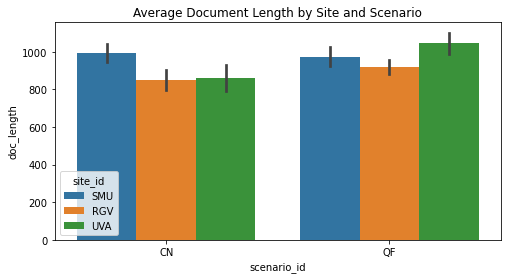

In [45]:
plt.figure(figsize=(8, 4))
sns.barplot(data=LIB, x='scenario_id', y='doc_length', hue='site_id', estimator=np.mean)
plt.title("Average Document Length by Site and Scenario")
plt.show()

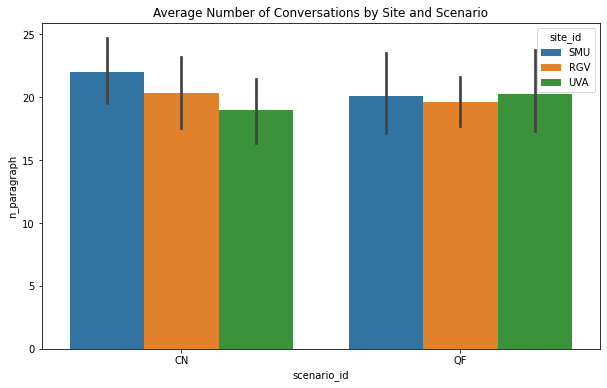

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(data=LIB, x='scenario_id', y='n_paragraph', hue='site_id', estimator=np.mean)
plt.title("Average Number of Conversations by Site and Scenario")
plt.show()

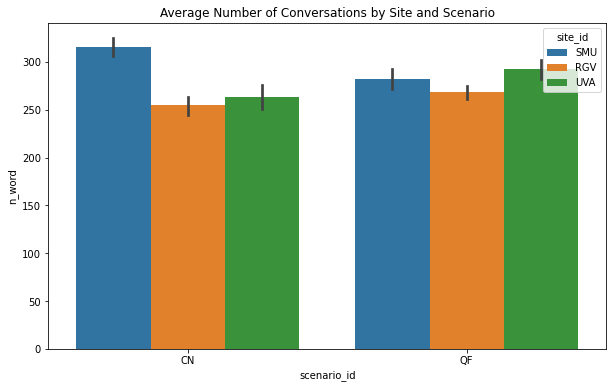

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=LIB, x='scenario_id', y='n_word', hue='site_id', estimator=np.mean)
plt.title("Average Number of Conversations by Site and Scenario")
plt.show()

In [90]:
TOKENS['term_str'] = TOKENS['term_str'].str.lower()

# Flag stop words and other unimportant words 

In [91]:
import nltk
from nltk.corpus import stopwords

In [96]:
# Create the set of stopwords
stop_words = set(stopwords.words('english'))

# Add a 'stopword_flag' column to the DataFrame
TOKENS['stopword_flag'] = TOKENS['term_str'].apply(lambda x: 1 if x in stop_words else 0)

In [99]:
##keep building this list back and forth
unimportant_list = ['okay', 'yeah']

In [100]:
# Add a 'unimportant_flag' column to the DataFrame
TOKENS['unimportant_flag'] = TOKENS['term_str'].apply(lambda x: 1 if x in unimportant_list else 0)

## Remove stop words and unimportant words

In [105]:
TOKENS = TOKENS.query("stopword_flag == 0 & unimportant_flag == 0")

In [106]:
TOKENS

term_str  POS  speaker  \
document_id    paragraph_id sentence_id token_id                             
02_004_22c_100 1            1           3               tell   VB  Kristyn   
                                        8               feel   VB  Kristyn   
                            2           2               give   VB  Kristyn   
                                        5           thoughts  NNS  Kristyn   
                            3           3               vent   VB  Kristyn   
...                                                      ...  ...      ...   
01_004_12c_008 25           7           5               dive   VB    Coach   
                                        9             second   JJ    Coach   
                                        10             round   NN    Coach   
                                        13        simulation   NN    Coach   
               26           1           3              ready   JJ  Teacher   

                                                  coach_flag  stopword_flag  \
document_id    paragraph_id sentence_id token_id                              
02_004_22c_100 1            1           3                  1              0   
                                        8                  1              0   
                            2           2                  1              0   
                                        5                  1              0   
                            3           3                  1              0   
...                                                      ...            ...   
01_004_12c_008 25           7           5                  1              0   
                                        9                  1              0   
                                        10                 1              0   
                                        13                 1              0   
               26           1           3                  0              0   

                                                  unimportant_flag  
document_id    paragraph_id sentence_id token_id                    
02_004_22c_100 1            1           3                        0  
                                        8                        0  
                            2           2                        0  
                                        5                        0  
                            3           3                        0  
...                                                            ...  
01_004_12c_008 25           7           5                        0  
                                        9                        0  
                                        10                       0  
                                        13                       0  
               26           1           3                        0  

[84190 rows x 6 columns]

# Exract VOCAB

Extract a vocabulary from the CORPUS as a whole

In [107]:
empty_rows = TOKENS['term_str'].isnull().sum()

In [108]:
empty_rows

1

In [109]:
TOKENS = TOKENS[TOKENS.term_str != '']

In [110]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['n_chars'] = VOCAB.index.str.len()

In [111]:
VOCAB

,n,p,i,n_chars
term_str,,,,
like,3702,0.043972,4.507255,4
think,1856,0.022046,5.503363,5
going,1298,0.015418,6.019269,5
want,1294,0.015370,6.023722,4
know,1148,0.013636,6.196437,4
...,...,...,...,...
sister,1,0.000012,16.361344,6
niceness,1,0.000012,16.361344,8
stems,1,0.000012,16.361344,5


## Add Max POS

In [112]:
VOCAB['max_pos'] = TOKENS[['term_str','POS']].value_counts().unstack(fill_value=0).idxmax(1)

In [113]:
VOCAB

,n,p,i,n_chars,max_pos
term_str,,,,,
like,3702,0.043972,4.507255,4,IN
think,1856,0.022046,5.503363,5,VBP
going,1298,0.015418,6.019269,5,VBG
want,1294,0.015370,6.023722,4,VBP
know,1148,0.013636,6.196437,4,VBP
...,...,...,...,...,...
sister,1,0.000012,16.361344,6,NN
niceness,1,0.000012,16.361344,8,NN
stems,1,0.000012,16.361344,5,NNS


## Compute POS ambiguity

How many POS categories are associated with each word?

In [114]:
VOCAB['n_pos'] = TOKENS[['term_str','POS']].value_counts().unstack().count(1)

In [115]:
VOCAB['cat_pos'] = TOKENS[['term_str','POS']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').POS.apply(lambda x: set(x))

In [116]:
VOCAB

,n,p,i,n_chars,max_pos,n_pos,cat_pos
term_str,,,,,,,
like,3702,0.043972,4.507255,4,IN,8,"{VBN, VBZ, IN, VBP, NN, RB, JJ, VB}"
think,1856,0.022046,5.503363,5,VBP,3,"{VB, VBP, NN}"
going,1298,0.015418,6.019269,5,VBG,1,{VBG}
want,1294,0.015370,6.023722,4,VBP,3,"{VB, VBP, NN}"
know,1148,0.013636,6.196437,4,VBP,4,"{NNS, VB, VBP, NN}"
...,...,...,...,...,...,...,...
sister,1,0.000012,16.361344,6,NN,1,{NN}
niceness,1,0.000012,16.361344,8,NN,1,{NN}
stems,1,0.000012,16.361344,5,NNS,1,{NNS}


## Add Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [117]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [118]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [121]:
#VOCAB[VOCAB.stop == 1].sample(10)
#no stop words because they're removed from corpus

## Add Stems

In [122]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [123]:
VOCAB.sample(10)

,n,p,i,n_chars,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
ethans,1,0.000012,16.361344,6,NNPS,1,{NNPS},0,ethan,ethan,eth
span,1,0.000012,16.361344,4,NN,1,{NN},0,span,span,span
graders,3,0.000036,14.776382,7,NNS,1,{NNS},0,grader,grader,grad
avidence,1,0.000012,16.361344,8,NN,1,{NN},0,avid,avid,avid
spsusecific,1,0.000012,16.361344,11,JJ,1,{JJ},0,spsusecif,spsusecif,spsusecific
concerned,2,0.000024,15.361344,9,JJ,2,"{VBN, JJ}",0,concern,concern,concern
conscious,1,0.000012,16.361344,9,JJ,1,{JJ},0,consciou,conscious,conscy
want,1294,0.015370,6.023722,4,VBP,3,"{VB, VBP, NN}",0,want,want,want
issue,5,0.000059,14.039416,5,NN,1,{NN},0,issu,issu,issu


# Create Bow Table from Corpus

In [124]:
bag = ['document_id', 'paragraph_id']

In [125]:
BOW = TOKENS.groupby(bag+['term_str']).term_str.count().to_frame('n') 

## Document-Term Count Matrix

In [126]:
DTCM = BOW.n.unstack().fillna(0).astype('int')

In [127]:
DTCM

term_str                          0  00  08  0r  1  10  100  11  12  123  ...  \
document_id         paragraph_id                                          ...   
01_004_12c_001      1             0   0   0   0  0   0    0   0   0    0  ...   
                    2             0   0   0   0  0   0    0   0   0    0  ...   
                    3             0   0   0   0  0   0    0   0   0    0  ...   
                    4             0   0   0   0  0   0    0   0   0    0  ...   
                    5             0   0   0   0  0   0    0   0   0    0  ...   
...                              ..  ..  ..  .. ..  ..  ...  ..  ..  ...  ...   
03_2022_004_22c_083 11            0   0   0   0  0   0    0   0   0    0  ...   
                    12            0   0   0   0  0   0    0   0   0    0  ...   
                    13            0   0   0   0  0   0    0   0   0    0  ...   
                    14            0   0   0   0  0   0    0   0   0    0  ...   
                    15            0   0   0   0  0   0    0   0   0    0  ...   

term_str                          yes  yesterday  yet  yooooo  york  young  \
document_id         paragraph_id                                             
01_004_12c_001      1               0          0    0       0     0      0   
                    2               0          0    0       0     0      0   
                    3               1          0    0       0     0      0   
                    4               0          0    0       0     0      0   
                    5               0          0    0       0     0      0   
...                               ...        ...  ...     ...   ...    ...   
03_2022_004_22c_083 11              0          0    0       0     0      0   
                    12              0          0    0       0     0      0   
                    13              0          0    0       0     0      0   
                    14              0          0    0       0     0      0   
                    15              0          0    0       0     0      0   

term_str                          younger  z  zero  zoom  
document_id         paragraph_id                          
01_004_12c_001      1                   0  0     0     0  
                    2                   0  0     0     0  
                    3                   0  0     0     0  
                    4                   0  0     0     0  
                    5                   0  0     0     0  
...                                   ... ..   ...   ...  
03_2022_004_22c_083 11                  0  0     0     0  
                    12                  0  0     0     0  
                    13                  0  0     0     0  
                    14                  0  0     0     0  
                    15                  0  0     0     0  

[3930 rows x 3632 columns]

## Different method to calculate TFIDF

In [128]:
def tf_idf(DTCM, tf_method):
   #define TF method
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
        
    TF = TF.T
    
    #calculate IDF
    DF = DTCM.astype('bool').sum()
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)

    #calculate TFIDF
    TFIDF = TF * IDF

    
    return DF, IDF, TF, TFIDF

### method 1 - max 

In [129]:
DF_1, IDF_1, TF_1, TFIDF_1 = tf_idf(DTCM, 'max')

In [130]:
TFIDF_1.mean().sort_values(ascending=False)

term_str
like             0.399627
think            0.324497
going            0.269174
right            0.261716
want             0.237532
                   ...   
dismissal        0.000092
expression       0.000092
cradle           0.000092
productivetoo    0.000092
hurdle           0.000092
Length: 3632, dtype: float64

### method 2- sum

In [131]:
DF_2, IDF_2, TF_2, TFIDF_2 = tf_idf(DTCM, 'sum')
TFIDF_2.mean().sort_values(ascending=False)

term_str
yes          0.077052
think        0.057471
like         0.054403
right        0.053111
thank        0.040143
               ...   
desirable    0.000012
offer        0.000011
filter       0.000011
eth          0.000011
tips         0.000011
Length: 3632, dtype: float64

### method 3 - log

In [132]:
DF_3, IDF_3, TF_3, TFIDF_3 = tf_idf(DTCM, 'log')
TFIDF_3.mean().sort_values(ascending=False)

term_str
like          0.892346
think         0.679329
want          0.614890
going         0.611789
know          0.579378
                ...   
prevent       0.003038
dear          0.003038
buying        0.003038
guided        0.003038
challenged    0.003038
Length: 3632, dtype: float64

## Save TFIDF into BOW table

In [133]:
#Method1-max
BOW['tf_max_method'] = TF_1.stack()
BOW['tfidf_max_method'] = TFIDF_1.stack()

In [134]:
#Method2-sum
BOW['tf_sum_method'] = TF_2.stack()
BOW['tfidf_sum_method'] = TFIDF_2.stack()

In [135]:
#Method3-log
BOW['tf_log_method'] = TF_3.stack()
BOW['tfidf_log_method'] = TFIDF_3.stack()

In [136]:
BOW

n  tf_max_method  \
document_id         paragraph_id term_str                      
01_004_12c_001      1            classroom  1            1.0   
                                 five       1            1.0   
                                 lucas      1            1.0   
                                 minute     1            1.0   
                                 quick      1            1.0   
...                                        ..            ...   
03_2022_004_22c_083 15           students   1            0.5   
                                 talking    1            0.5   
                                 time       1            0.5   
                                 using      1            0.5   
                                 want       1            0.5   

                                            tfidf_max_method  tf_sum_method  \
document_id         paragraph_id term_str                                     
01_004_12c_001      1            classroom          3.631975       0.100000   
                                 five               5.963034       0.100000   
                                 lucas             11.940314       0.100000   
                                 minute             7.239874       0.100000   
                                 quick              5.831789       0.100000   
...                                                      ...            ...   
03_2022_004_22c_083 15           students           1.343824       0.032258   
                                 talking            1.825147       0.032258   
                                 time               1.616477       0.032258   
                                 using              2.318266       0.032258   
                                 want               1.224230       0.032258   

                                            tfidf_sum_method  tf_log_method  \
document_id         paragraph_id term_str                                     
01_004_12c_001      1            classroom          0.363197            1.0   
                                 five               0.596303            1.0   
                                 lucas              1.194031            1.0   
                                 minute             0.723987            1.0   
                                 quick              0.583179            1.0   
...                                                      ...            ...   
03_2022_004_22c_083 15           students           0.086698            1.0   
                                 talking            0.117751            1.0   
                                 time               0.104289            1.0   
                                 using              0.149566            1.0   
                                 want               0.078983            1.0   

                                            tfidf_log_method  
document_id         paragraph_id term_str                     
01_004_12c_001      1            classroom          3.631975  
                                 five               5.963034  
                                 lucas             11.940314  
                                 minute             7.239874  
                                 quick              5.831789  
...                                                      ...  
03_2022_004_22c_083 15           students           2.687648  
                                 talking            3.650295  
                                 time               3.232954  
                                 using              4.636533  
                                 want               2.448461  

[64128 rows x 7 columns]

## Save TFIDF into VACOB

In [137]:
# Using max method
VOCAB['df'] = DF_1
VOCAB['idf'] = IDF_1

VOCAB['tfidf_mean'] = TFIDF_1.mean() 
VOCAB['tfidf_sum'] = TFIDF_1.sum()
VOCAB['tfidf_median'] = TFIDF_1.median()
VOCAB['tfidf_max'] = TFIDF_1.max()

VOCAB['dfidf'] = VOCAB.df * VOCAB.idf

In [138]:
VOCAB

,n,p,i,n_chars,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster,df,idf,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max,dfidf
term_str,,,,,,,,,,,,,,,,,,
like,3702,0.043972,4.507255,4,IN,8,"{VBN, VBZ, IN, VBP, NN, RB, JJ, VB}",0,like,like,lik,1338,1.554451,0.399627,1570.532532,0.0,1.554451,2079.855701
think,1856,0.022046,5.503363,5,VBP,3,"{VB, VBP, NN}",0,think,think,think,1114,1.818780,0.324497,1275.274595,0.0,1.818780,2026.121009
going,1298,0.015418,6.019269,5,VBG,1,{VBG},0,go,go,going,724,2.440468,0.269174,1057.854836,0.0,2.440468,1766.898622
want,1294,0.015370,6.023722,4,VBP,3,"{VB, VBP, NN}",0,want,want,want,720,2.448461,0.237532,933.499400,0.0,2.448461,1762.891561
know,1148,0.013636,6.196437,4,VBP,4,"{NNS, VB, VBP, NN}",0,know,know,know,688,2.514049,0.216470,850.728825,0.0,2.514049,1729.665604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sister,1,0.000012,16.361344,6,NN,1,{NN},0,sister,sister,sist,1,11.940314,0.000506,1.990052,0.0,1.990052,11.940314
niceness,1,0.000012,16.361344,8,NN,1,{NN},0,nice,nice,nic,1,11.940314,0.001013,3.980105,0.0,3.980105,11.940314
stems,1,0.000012,16.361344,5,NNS,1,{NNS},0,stem,stem,stem,1,11.940314,0.000506,1.990052,0.0,1.990052,11.940314


# Save

In [139]:
out_path = f'{data_home}/output/'

In [140]:
LIB.to_csv(f'{out_path}/LIB.csv')
VOCAB.to_csv(f'{out_path}/VOCAB.csv')
TOKENS.to_csv(f'{out_path}/CORPUS.csv')
BOW.to_csv(f'{out_path}/BOW.csv')